In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load spaCy model
print("Loading spaCy model...")
nlp = spacy.load("en_core_web_sm")

Loading spaCy model...


In [52]:
class SpacyFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, pos=True, ner=True, dep=False):
        self.pos = pos
        self.ner = ner
        self.dep = dep
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Process text with spaCy
        docs = [nlp(text) for text in X]
        features = []
        
        for doc in docs:
            doc_features = {}
            
            # Extract POS tag features
            if self.pos:
                pos_counts = Counter([token.pos_ for token in doc])
                for pos, count in pos_counts.items():
                    doc_features[f'POS_{pos}'] = count
            
            # Extract NER features
            if self.ner:
                ner_counts = Counter([ent.label_ for ent in doc.ents])
                for ner, count in ner_counts.items():
                    doc_features[f'NER_{ner}'] = count
                
                # Flag presence of entity types
                entity_types = set([ent.label_ for ent in doc.ents])
                for entity_type in entity_types:
                    doc_features[f'HAS_NER_{entity_type}'] = 1
                
                # Count total entities
                doc_features['TOTAL_ENTITIES'] = len(doc.ents)
            
            # Extract dependency features
            if self.dep:
                dep_counts = Counter([token.dep_ for token in doc])
                for dep, count in dep_counts.items():
                    doc_features[f'DEP_{dep}'] = count
            
            features.append(doc_features)
        
        return features

In [4]:
# Load the training data
train_data = pd.read_csv('data/train.csv')

# Display first few rows to understand the data
train_data.head()

,Sentence_id,Text,Verdict
0,1,I think we've seen a deterioration of values.,-1
1,2,I think for a while as a nation we condoned th...,-1
2,3,"For a while, as I recall, it even seems to me ...",-1
3,4,"So we've seen a deterioration in values, and o...",-1
4,5,"We got away, we got into this feeling that val...",-1


In [5]:
# Split data into features and target
X = train_data['Text']
y = train_data['Verdict']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_val.shape)

Train shape: (18000,) Test shape: (4501,)


In [18]:

spacy_pipeline = Pipeline([
    ('spacy', SpacyFeatures(pos=True, ner=True, dep=False)),
    ('dict_vect', DictVectorizer())
])
features = FeatureUnion([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('spacy', spacy_pipeline)
])

# Full pipeline
pipeline = Pipeline([
    ('features', features),
    ('classifier', SVC(class_weight='balanced'))
])


pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(max_features=5000,
                                                                 ngram_range=(1,
                                                                              2))),
                                                ('spacy',
                                                 Pipeline(steps=[('spacy',
                                                                  SpacyFeatures()),
                                                                 ('dict_vect',
                                                                  DictVectorizer())]))])),
                ('classifier', SVC(class_weight='balanced'))])

In [19]:
from sklearn.metrics import confusion_matrix, f1_score

# Evaluate on validation set
y_pred = pipeline.predict(X_val)

# Calculate metrics
validation_accuracy = accuracy_score(y_val, y_pred)
validation_f1_macro = f1_score(y_val, y_pred, average='macro')
validation_f1_per_class = f1_score(y_val, y_pred, average=None)

# Print metrics
print("\nValidation set performance:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {validation_accuracy:.4f}")
print(f"Macro F1 Score: {validation_f1_macro:.4f}")
print(f"F1 Score per class:")
for i, score in enumerate(validation_f1_per_class):
    class_label = {-1: "Not Factual", 0: "Unimportant Fact", 1: "Important Fact"}.get(i-1, f"Class {i-1}")
    print(f"  {class_label}: {score:.4f}")



Validation set performance:
              precision    recall  f1-score   support

          -1       0.84      0.69      0.76      2926
           0       0.23      0.45      0.30       502
           1       0.54      0.54      0.54      1073

    accuracy                           0.63      4501
   macro avg       0.54      0.56      0.54      4501
weighted avg       0.70      0.63      0.66      4501

Accuracy: 0.6319
Macro F1 Score: 0.5358
F1 Score per class:
  Not Factual: 0.7584
  Unimportant Fact: 0.3044
  Important Fact: 0.5445


Confusion matrix saved as 'confusion_matrix.png'


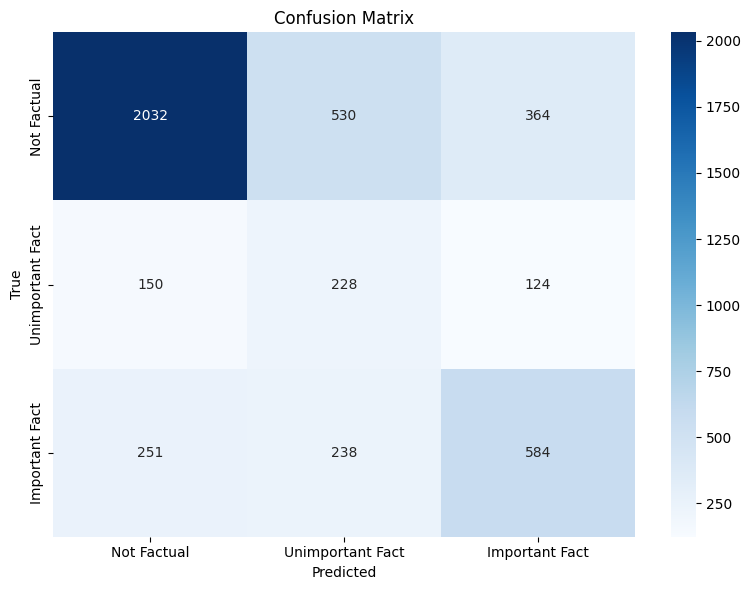

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create and plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [21]:
# Train on full training data with best parameters
print("\nTraining final model on all training data...")
pipeline.fit(X, y)


Training final model on all training data...


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(max_features=5000,
                                                                 ngram_range=(1,
                                                                              2))),
                                                ('spacy',
                                                 Pipeline(steps=[('spacy',
                                                                  SpacyFeatures()),
                                                                 ('dict_vect',
                                                                  DictVectorizer())]))])),
                ('classifier', SVC(class_weight='balanced'))])

In [22]:
# Save the model
joblib.dump(pipeline, 'feature_svm_model.pkl')
print("Model saved as 'feature_svm_model.pkl'")

Model saved as 'feature_svm_model.pkl'


In [23]:
# Function to make predictions on test data
def predict_test_data(model_path, test_path, output_path):
    # Load the model and test data
    model = joblib.load(model_path)
    test_data = pd.read_csv(test_path)
    
    features_transformer = model.named_steps['features']
    
    # Transform the test data
    X_test_transformed = features_transformer.transform(test_data['Text'])
    
    # Make predictions using the classifier
    predictions = model.named_steps['classifier'].predict(X_test_transformed)
    
    
    # Create output DataFrame
    output_df = pd.DataFrame({
        'Sentence_id': test_data['Sentence_id'],
        'Verdict': predictions
    })
    
    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


print("\nMaking predictions on test data...")
predict_test_data('feature_svm_model.pkl', 'data/test.csv', 'data/feature_svm_predictions.csv')


Making predictions on test data...
Predictions saved to data/feature_svm_predictions.csv


Kaggle score: 0.67737

# using NN with the features

In [142]:
from skorch import NeuralNetClassifier
import torch.nn as nn
import torch.nn.functional as F
import torch

# Define your PyTorch model.
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=32, num_classes=3, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        
        self.dropout = nn.Dropout(dropout_rate)

        self.bn2 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)

        self.fc3 = nn.Linear(hidden_dim2, num_classes)
    
    def forward(self, x):
        # x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.bn2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)
        return x

In [143]:
spacy_pipeline = Pipeline([
    ('spacy', SpacyFeatures(pos=True, ner=True, dep=True)),
    ('dict_vect', DictVectorizer())
])
features = FeatureUnion([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('spacy', spacy_pipeline)
])



In [144]:
class_counts = y_train.value_counts()
class_weights = 1.0 / class_counts  # Inverse frequency of each class
weights = torch.tensor(class_weights.values, dtype=torch.float32)

net = NeuralNetClassifier(
    module=SimpleNN,
    module__input_dim=3099,   # pass the calculated input dimension
    module__num_classes=3,
    max_epochs=15,
    lr=0.001,
    criterion=nn.CrossEntropyLoss(weight=weights),  # Loss function
    optimizer=torch.optim.Adam,
    batch_size=64,
    optimizer__weight_decay=1e-5,  
    iterator_train__shuffle=True,
    # You can also pass other skorch parameters here.
)

class ToFloat32Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.astype(np.float32)

pipeline = Pipeline([
    ('features', features),
    ('to_float32', ToFloat32Transformer()),
    ('classifier', net)
])

value_to_idx = {
    -1: 0,
    0: 1,
    1: 2
}
pipeline.fit(X_train, y_train.map(value_to_idx))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8186       0.6019        0.7369  1.0993
      2        0.7134       0.5514        0.7063  1.0124
      3        0.6764       0.6711        0.6527  0.7455
      4        0.6487       0.6906        0.6501  0.6905
      5        0.6154       0.6928        0.6356  0.7224
      6        0.5972       0.6728        0.6314  0.7110
      7        0.5823       0.6481        0.6311  0.6999
      8        0.5686       0.6800        0.6391  0.7233
      9        0.5514       0.7231        0.6609  0.7605
     10        0.5351       0.6778        0.6560  0.7099
     11        0.5285       0.6828        0.6633  0.6877
     12        0.5175       0.7178        0.6892  0.7011
     13        0.5071       0.7358        0.7319  0.7195
     14        0.4862       0.7039        0.6799  0.6918
     15        0.4805       0.6958        0.6955  0.6895


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(max_features=3000,
                                                                 ngram_range=(1,
                                                                              2))),
                                                ('spacy',
                                                 Pipeline(steps=[('spacy',
                                                                  SpacyFeatures(dep=True)),
                                                                 ('dict_vect',
                                                                  DictVectorizer())]))])),
                ('to_float32', ToFloat32Transformer()),
                ('classifier',
                 NeuralNetClassifier(_params_to_validate={'iterator_train__shuffle', 'module__num_..._shuffle=True, iterator_valid=<class 'torch.utils.data.dataloader.DataLoader'>, lr=0.001, max_epochs=15, module=<class '__main__.SimpleNN'>, module__input_dim=3099, module__num_classes=3, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__weight_decay=1e-05, predict_nonlinearity='auto', torch_load_kwargs=None, use_caching='auto', verbose=1, warm_start=False))])

In [145]:
from sklearn.metrics import confusion_matrix, f1_score

# Evaluate on validation set
# X_val_transformed = features.fit_transform(X_val)
y_pred = pipeline.predict(X_val)
y_pred = y_pred - 1

# Calculate metrics
validation_accuracy = accuracy_score(y_val, y_pred)
validation_f1_macro = f1_score(y_val, y_pred, average='macro')
validation_f1_per_class = f1_score(y_val, y_pred, average=None)

# Print metrics
print("\nValidation set performance:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {validation_accuracy:.4f}")
print(f"Macro F1 Score: {validation_f1_macro:.4f}")
print(f"F1 Score per class:")
for i, score in enumerate(validation_f1_per_class):
    class_label = {-1: "Not Factual", 0: "Unimportant Fact", 1: "Important Fact"}.get(i-1, f"Class {i-1}")
    print(f"  {class_label}: {score:.4f}")



Validation set performance:
              precision    recall  f1-score   support

          -1       0.91      0.73      0.81      2926
           0       0.40      0.32      0.36       502
           1       0.51      0.83      0.63      1073

    accuracy                           0.71      4501
   macro avg       0.61      0.63      0.60      4501
weighted avg       0.76      0.71      0.72      4501

Accuracy: 0.7072
Macro F1 Score: 0.5984
F1 Score per class:
  Not Factual: 0.8077
  Unimportant Fact: 0.3560
  Important Fact: 0.6316


Confusion matrix saved as 'confusion_matrix.png'


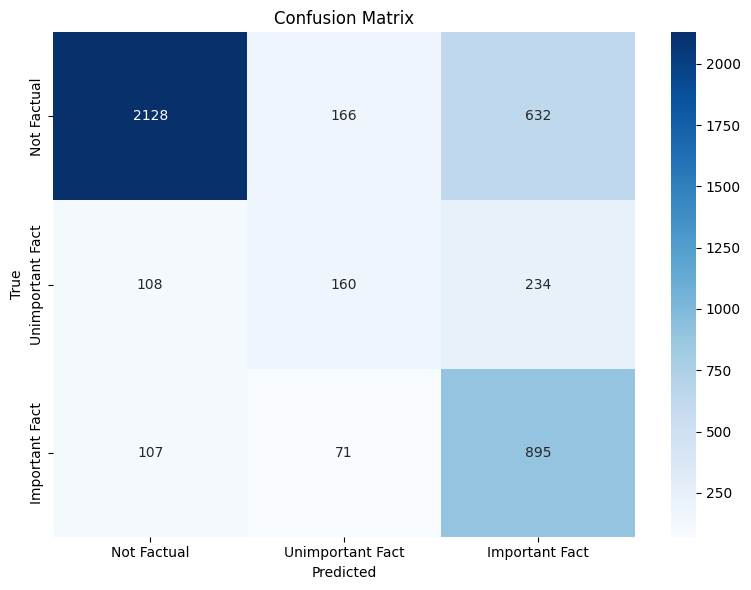

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create and plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [148]:
# Train on full training data with best parameters
# print("\nTraining final model on all training data...")
# pipeline.fit(X, y)

# Save the model
import pickle


with open('feature_nn_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [147]:
print("\nMaking predictions on test data...")

test_path = 'data/test.csv'
output_path = 'data/feature_nn_predictions.csv'
test_data = pd.read_csv(test_path)
    
predictions = pipeline.predict(test_data['Text']) - 1
    # Create output DataFrame
output_df = pd.DataFrame({
    'Sentence_id': test_data['Sentence_id'],
    'Verdict': predictions
})

# Save to CSV
output_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")




Making predictions on test data...
Predictions saved to data/feature_nn_predictions.csv


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleNN(
    (bn1): BatchNorm1d(3099, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=3099, out_features=128, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=128, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=3, bias=True)
  ),
)

Validation set performance:
              precision    recall  f1-score   support

          -1       0.88      0.45      0.60      2926
           0       0.24      0.35      0.29       502
           1       0.37      0.77      0.50      1073

    accuracy                           0.52      4501
   macro avg       0.49      0.52      0.46      4501
weighted avg       0.68      0.52      0.54      4501

Accuracy: 0.5177
Macro F1 Score: 0.4602
F1 Score per class:
  Not Factual: 0.5985
  Unimportant Fact: 0.2869
  Important Fact: 0.4953

kaggle score: 0.79605

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleNN(
    (bn1): BatchNorm1d(3099, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=3099, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=128, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=3, bias=True)
  ),
)

Validation set performance:
              precision    recall  f1-score   support

          -1       0.91      0.73      0.81      2926
           0       0.40      0.32      0.36       502
           1       0.51      0.83      0.63      1073

    accuracy                           0.71      4501
   macro avg       0.61      0.63      0.60      4501
weighted avg       0.76      0.71      0.72      4501

Accuracy: 0.7072
Macro F1 Score: 0.5984
F1 Score per class:
  Not Factual: 0.8077
  Unimportant Fact: 0.3560
  Important Fact: 0.6316

In [ ]:
k